In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
groups = ["british", "lifestyle"]

gene_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/genes.list",
    ]

go_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/GO_Biological_Process_2023_enrich.csv",
]

kegg_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/lifestyle/KEGG_2021_Human_enrich.csv",
]

In [3]:
def read_genes(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(group_sets, groups):
    # get the set of items for each group
    item_dict = {g: s for g,s in zip(groups, group_sets)}
    item_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_items = list(combinations(groups, i))
        for items in all_items:
            # get counts of elements that are unique to the group
            include_items = items
            exclude_items = tuple(g for g in groups if g not in include_items)
            include_sets = [item_dict[c] for c in include_items]
            exclude_sets = [item_dict[c] for c in exclude_items]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_items, exclude_items)] = unique_intersects
            for c in include_items:
                item_boolean_dict[c].append(True)
            for c in exclude_items:
                item_boolean_dict[c].append(False)
    item_boolean_dict["counts"] = counts
    df = pd.DataFrame(item_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

# Genes

In [4]:
group_genes = list(map(read_genes, gene_files))

In [5]:
gene_upset_df, gene_unique_intersects = get_upset_df(group_genes, groups)

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

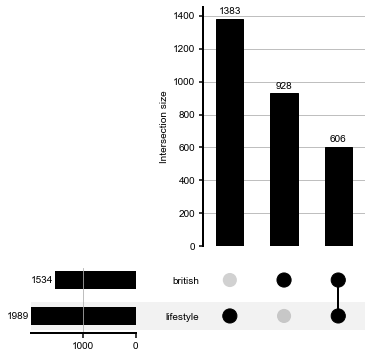

In [6]:
parsed_gene_upset_df = gene_upset_df.loc[gene_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_gene_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

# GO terms

In [7]:
def read_enrich_files(filename):
    df = pd.read_csv(filename)
    df = df.loc[df.adj_pval<0.05]
    return set(df["Term"])

In [8]:
group_gos = list(map(read_enrich_files, go_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

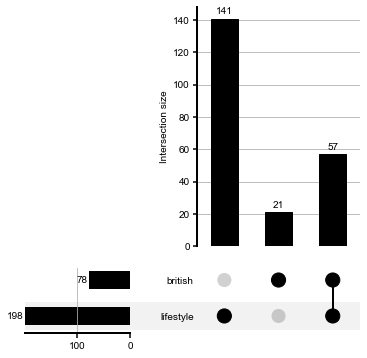

In [9]:
go_upset_df, go_unique_intersects = get_upset_df(group_gos, groups)
parsed_go_upset_df = go_upset_df.loc[go_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_go_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [10]:
go_unique_intersects.keys()

dict_keys([(('british',), ('lifestyle',)), (('lifestyle',), ('british',)), (('british', 'lifestyle'), ())])

In [11]:
go_unique_intersects[(('british', 'lifestyle'), ())]

{'Actin Filament Organization (GO:0007015)',
 'Actin Filament-Based Transport (GO:0099515)',
 'Actin-Myosin Filament Sliding (GO:0033275)',
 'Actomyosin Structure Organization (GO:0031032)',
 'Branching Morphogenesis Of An Epithelial Tube (GO:0048754)',
 'Calcium Ion Import Across Plasma Membrane (GO:0098703)',
 'Calcium Ion Transmembrane Import Into Cytosol (GO:0097553)',
 'Calcium Ion Transmembrane Transport (GO:0070588)',
 'Calcium Ion Transport (GO:0006816)',
 'Cardiac Conduction (GO:0061337)',
 'Cardiac Muscle Contraction (GO:0060048)',
 'Chloride Transport (GO:0006821)',
 'Collagen Fibril Organization (GO:0030199)',
 'Epithelial Cell Differentiation (GO:0030855)',
 'Epithelium Development (GO:0060429)',
 'External Encapsulating Structure Organization (GO:0045229)',
 'Extracellular Matrix Organization (GO:0030198)',
 'Extracellular Structure Organization (GO:0043062)',
 'Glucan Catabolic Process (GO:0009251)',
 'Glutamate Receptor Signaling Pathway (GO:0007215)',
 'Heart Contracti

In [12]:
go_unique_intersects[(('lifestyle',), ('british',))]

{'ATP Metabolic Process (GO:0046034)',
 'AV Node Cell Action Potential (GO:0086016)',
 'Action Potential (GO:0001508)',
 'Amino Acid Transmembrane Transport (GO:0003333)',
 'Ammonium Transmembrane Transport (GO:0072488)',
 'Anterograde Trans-Synaptic Signaling (GO:0098916)',
 'Aortic Valve Development (GO:0003176)',
 'Aortic Valve Morphogenesis (GO:0003180)',
 'Artery Morphogenesis (GO:0048844)',
 'Atrioventricular Valve Development (GO:0003171)',
 'Atrioventricular Valve Morphogenesis (GO:0003181)',
 'Axonemal Dynein Complex Assembly (GO:0070286)',
 'Bicarbonate Transport (GO:0015701)',
 'Bundle Of His Cell To Purkinje Myocyte Communication (GO:0086069)',
 'COPII-coated Vesicle Cargo Loading (GO:0090110)',
 'Calcium Ion Homeostasis (GO:0055074)',
 'Carbohydrate Catabolic Process (GO:0016052)',
 'Carbohydrate Phosphorylation (GO:0046835)',
 'Cardiac Muscle Cell Action Potential (GO:0086001)',
 'Cardiac Muscle Cell Development (GO:0055013)',
 'Cardiac Muscle Tissue Morphogenesis (GO:005

# KEGG terms

In [13]:
group_keggs = list(map(read_enrich_files, kegg_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


(0.0, 1.0, 0.0, 1.0)

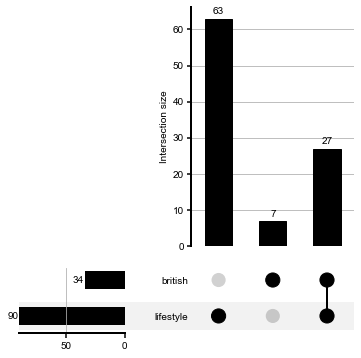

In [14]:
kegg_upset_df, kegg_unique_intersects = get_upset_df(group_keggs, groups)
parsed_kegg_upset_df = kegg_upset_df.loc[kegg_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_kegg_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [15]:
kegg_unique_intersects[(('british', 'lifestyle'), ())]

{'ABC transporters',
 'Arrhythmogenic right ventricular cardiomyopathy',
 'Ascorbate and aldarate metabolism',
 'Bile secretion',
 'Breast cancer',
 'Carbohydrate digestion and absorption',
 'Chemical carcinogenesis',
 'Cholinergic synapse',
 'Dilated cardiomyopathy',
 'Drug metabolism',
 'ECM-receptor interaction',
 'Focal adhesion',
 'Fructose and mannose metabolism',
 'Galactose metabolism',
 'Glycine serine and threonine metabolism',
 'Human papillomavirus infection',
 'Hypertrophic cardiomyopathy',
 'Metabolism of xenobiotics by cytochrome P450',
 'PI3K-Akt signaling pathway',
 'Pathways of neurodegeneration',
 'Pentose and glucuronate interconversions',
 'Porphyrin and chlorophyll metabolism',
 'Protein digestion and absorption',
 'Retinol metabolism',
 'Starch and sucrose metabolism',
 'Steroid hormone biosynthesis',
 'Vitamin digestion and absorption'}

In [16]:
kegg_unique_intersects.keys()

dict_keys([(('british',), ('lifestyle',)), (('lifestyle',), ('british',)), (('british', 'lifestyle'), ())])

# KEGG unique intersect genes

## Lifestyle

In [17]:
def get_unique_genes_from_terms(enrich_df, term_unique_intersects, gene_unique_intersects, ut_key):
    unique_terms = term_unique_intersects[ut_key]
    enrich_df = enrich_df.loc[enrich_df.Term.isin(unique_terms)]
    unique_genes = gene_unique_intersects[ut_key]
    enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))
    return enrich_df
    

In [18]:
kegg_lifetyle_df = pd.read_csv(kegg_enrich_files[1])
kegg_lifetyle_df = get_unique_genes_from_terms(kegg_lifetyle_df, kegg_unique_intersects, gene_unique_intersects,(('lifestyle',), ('british',)))

/tmp/ipykernel_12056/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [19]:
go_lifetyle_df = pd.read_csv(go_enrich_files[1])
go_lifetyle_df = get_unique_genes_from_terms(go_lifetyle_df, go_unique_intersects, gene_unique_intersects,(('lifestyle',), ('british',)))

/tmp/ipykernel_12056/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [20]:
go_lifetyle_df.head(50)

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
22,Monoatomic Cation Transport (GO:0006812),1.310747e-08,0.000002,6.950452,126.151291,ANO6|PIEZO2|ATP10D|TRPM7|CNGA2|ANO1|PIEZO1|MCO...
25,Monoatomic Ion Transport (GO:0006811),3.207145e-08,0.000005,3.651259,63.003565,PIEZO2|ATP10D|SLC15A1|CHRNA4|TRPM3|TRPA1|CTNS|...
31,Chloride Ion Homeostasis (GO:0055064),1.383190e-07,0.000017,67.024735,1058.568752,SLC12A8|SLC12A7|SLC12A2|SLC12A9
32,Monoatomic Anion Homeostasis (GO:0055081),1.383190e-07,0.000017,67.024735,1058.568752,SLC12A8|SLC12A7|SLC12A2|SLC12A9
34,Chloride Transmembrane Transport (GO:1902476),1.798375e-07,0.000021,5.510432,85.583695,ANO6|CLCN3|GABRA6|SLC12A7|SLC12A9|ANO5|GABRG1|...
36,Carbohydrate Catabolic Process (GO:0016052),2.343870e-07,0.000026,6.212519,94.842128,PGK2|HK3|PKM|LDHA|NEU4|GPI|HKDC1|HK2|PFKL|PGAM...
38,G Protein-Coupled Glutamate Receptor Signaling...,2.943992e-07,0.000031,25.143939,378.122838,GRM2|GRM4|HOMER1|GRM7
45,Regulation Of Extracellular Matrix Organizatio...,9.522826e-07,0.000086,9.152711,126.896879,LAMA1|NID1|LAMA2|RUNX1|FGFR4|LAMB2|CEL
49,Monoatomic Anion Transmembrane Transport (GO:0...,1.521709e-06,0.000127,4.564133,61.139655,ANO6|CLCN3|GABRA6|SLC12A7|SLC12A9|ANO5|GABRG1|...
50,Lipid Translocation (GO:0034204),1.718789e-06,0.000140,8.389479,111.361026,ATP8A1|ATP10D|ATP8B3|ATP8B4|ATP9B|ATP10B|SLC66A2


In [21]:
go_lifetyle_df.loc[go_lifetyle_df.Term.str.contains("Cholesterol Transport")].genes.values[0]

'SERAC1|ABCG8|LIPC|LCAT|CAV1|ABCA8|NPC2|APOB|LIMA1|CEL|ABCG5'

In [22]:
go_lifetyle_df.loc[go_lifetyle_df.Term.str.contains("Central Nervous System Development"), "genes"].values[0]

'CNTNAP2|CHD8|COL4A1|ELP3|SNTG2|ADGRL2|SPATA5|APEX1|VAX1|SOX8|CTNS|BTD|TPP1|PAX8|PKD2|NIPBL|AGTR2|PRKN|ZFHX2|SETD1A|CELSR1|CNTN6|QARS1|CNTN5|PKD1|DNER|GSN|GRIK1|MELTF|ADGRA2|PAX6|ZFHX3|SYNJ2'

In [23]:
go_lifetyle_df.sort_values("adj_pval").head(50)

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
22,Monoatomic Cation Transport (GO:0006812),1.310747e-08,0.000002,6.950452,126.151291,ANO6|PIEZO2|ATP10D|TRPM7|CNGA2|ANO1|PIEZO1|MCO...
25,Monoatomic Ion Transport (GO:0006811),3.207145e-08,0.000005,3.651259,63.003565,PIEZO2|ATP10D|SLC15A1|CHRNA4|TRPM3|TRPA1|CTNS|...
31,Chloride Ion Homeostasis (GO:0055064),1.383190e-07,0.000017,67.024735,1058.568752,SLC12A8|SLC12A7|SLC12A2|SLC12A9
32,Monoatomic Anion Homeostasis (GO:0055081),1.383190e-07,0.000017,67.024735,1058.568752,SLC12A8|SLC12A7|SLC12A2|SLC12A9
34,Chloride Transmembrane Transport (GO:1902476),1.798375e-07,0.000021,5.510432,85.583695,ANO6|CLCN3|GABRA6|SLC12A7|SLC12A9|ANO5|GABRG1|...
36,Carbohydrate Catabolic Process (GO:0016052),2.343870e-07,0.000026,6.212519,94.842128,PGK2|HK3|PKM|LDHA|NEU4|GPI|HKDC1|HK2|PFKL|PGAM...
38,G Protein-Coupled Glutamate Receptor Signaling...,2.943992e-07,0.000031,25.143939,378.122838,GRM2|GRM4|HOMER1|GRM7
45,Regulation Of Extracellular Matrix Organizatio...,9.522826e-07,0.000086,9.152711,126.896879,LAMA1|NID1|LAMA2|RUNX1|FGFR4|LAMB2|CEL
49,Monoatomic Anion Transmembrane Transport (GO:0...,1.521709e-06,0.000127,4.564133,61.139655,ANO6|CLCN3|GABRA6|SLC12A7|SLC12A9|ANO5|GABRG1|...
50,Lipid Translocation (GO:0034204),1.718789e-06,0.000140,8.389479,111.361026,ATP8A1|ATP10D|ATP8B3|ATP8B4|ATP9B|ATP10B|SLC66A2
